In [1]:
import numpy as np
import math
from sklearn.preprocessing import scale
from copy import deepcopy
import matplotlib.pyplot as plt


在这个notebook里我分别用stagewise, lars 和coordinate Descent 三种方法对diabetes数据集做模型选择, 因为只考虑线性模型, 所以用LinearRegression 这个class作为父类, 分别往下做继承 

In [19]:
class LinearRegression:

    def __init__(self):
        self.fit_intercept = None
        self.coef_ = None
        self.intercept_ = None
        self.coef_path = None
        self.iter_step = None
        self.beta_ols = None
        self.method = None

    def ols(self, X_in, y_in):
        n, p = X_in.shape
        X = scale(X_in) / np.sqrt(n)
        y = y_in - np.mean(y_in)  # 标准化之后intercept == 0, fit_intercept 取值没有实际影响
        y = y.reshape(n, 1)
        G = X.T @ X
        if np.linalg.matrix_rank(G) == p:
            self.beta_ols = np.linalg.inv(G) @ X.T @ y
        else:
            print('No ols solution')

        return self
    
    # 用测试数据X_test进行predict
    def predict(self, X_test):
        y_predicted = np.dot(X_test, self.coef_)
        if self.fit_intercept:
            y_predicted += self.intercept_ * np.ones([len(y_predicted), 1])

        return y_predicted

首先做的是forward stagewise, 这个方法非常简单, 这里按照 lars_2002 那篇文章直接实现

In [3]:
class stagewise(LinearRegression):

    def __init__(self, max_iter=10000):
        LinearRegression.__init__(self)

        self.method = 'Forward_Stagewise'
        self.max_iter = max_iter

    def fit(self, X_in, y_in, fit_intercept=False, Path=False, N_para=None):
        self.fit_intercept = fit_intercept
        n, p = X_in.shape
        if Path:
            if fit_intercept:
                self.coef_path = np.zeros([p, 1])
            else:
                self.coef_path = np.zeros([p, 0])

        if self.fit_intercept:
            self.intercept_ = np.mean(y_in)

        X = scale(X_in) / np.sqrt(n)
        y = y_in - np.mean(y_in)  # 标准化之后intercept == 0, fit_intercept 取值没有实际影响
        y = y.reshape(n, 1)

        mu = np.zeros([n, 1])
        eps = 0.3 # 这个参数不同情况下应该有不同选择, 和C_max的尺度有关
        k = 0
        iter_step = 0
        Xp = np.zeros([n, 0])
        Ind = []
        
        if N_para:
            P = N_para
        else:
            P = p

        while k < P+1 and iter_step < self.max_iter:
            c = X.T @ (y - mu)
            ind = np.argmax(np.abs(c)) # C_max = c[np.argmax(np.abs(c))]
            bo = ind in Ind

            if not bo:
                Ind.append(ind)
                Xp = np.column_stack((Xp, X[:, ind]))
                k += 1
                if Path:
                    beta = np.linalg.inv(X.T @ X) @ X.T @ mu

                    self.coef_path = np.column_stack((self.coef_path, beta))

            delt_mu = eps * np.sign(c[ind]) * X[:, ind]
            mu += delt_mu.reshape(n, 1)
            iter_step += 1

        if k == p and Path:
            self.ols(X_in, y_in)
            self.coef_path = np.column_stack((self.coef_path, self.beta_ols))

        beta = np.linalg.inv(X.T @ X) @ X.T @ mu

        self.coef_ = beta
        self.iter_step = iter_step
        return self


lars 后续还应该有一个对lasso的modified version

In [4]:
class lars(LinearRegression):
    def __init__(self):
        LinearRegression.__init__(self)

        self.method = 'LARS'

    def fit(self, X_in, y_in, fit_intercept=True, Path=True, N_para=None):
        n, p = X_in.shape
        self.fit_intercept = fit_intercept
        if Path:
            if fit_intercept:
                self.coef_path = np.zeros([p, 1])
            else:
                self.coef_path = np.zeros([p, 0])

        if self.fit_intercept:
            self.intercept_ = np.mean(y_in) 

        X = scale(X_in) / np.sqrt(n)
        y = y_in - np.mean(y_in)
        y = y.reshape(n, 1)

            
        Ind_A = []
        Ind_Ac = list(range(p))
        muA_hat = np.zeros([n, 1])
        # notation from lars_2002 eq(2.5), (2.6)
        Xa = np.zeros([n, 0])
        
        if N_para:
            P = N_para
        else:
            P = p

        while len(Ind_A) < P:
            c = X.T @ (y - muA_hat)
            ind = Ind_Ac[np.argmax(np.abs(c[Ind_Ac]))]
            C_max = np.abs(c[ind])
            Ind_A.append(ind)
            Ind_Ac.remove(ind)
            ones_A = np.ones([len(Ind_A), 1])
            Xa = np.column_stack((Xa, np.sign(c[ind]) * X[:, ind]))
            Ga = Xa.T @ Xa
            Ga_inv = np.linalg.inv(Ga)  # The better way required cholsky
            Aa = 1 / np.sqrt(ones_A.T @ Ga_inv @ ones_A)
            wa = Aa * Ga_inv @ ones_A
            mu_A = Xa @ wa
            a = X.T @ mu_A

            # (2,13)
            eta = 1e10
            for j in Ind_Ac:
                eta_m = (C_max - c[j]) / (Aa - a[j])
                if eta_m < 0:
                    eta_m = 1e8

                eta_p = (C_max + c[j]) / (Aa + a[j])
                if eta_p < 0:
                    eta_p = 1e8
                eta = min(eta_p, eta_m, eta)

            if len(Ind_Ac) == 0:
                eta = C_max / Aa
            # new mu
            muA_hat += eta * mu_A

            if Path:
                beta = np.linalg.inv(X.T @ X) @ X.T @ muA_hat
                self.coef_path = np.column_stack((self.coef_path, beta))

        self.coef_ = np.linalg.inv(X.T @ X) @ X.T @ muA_hat
        self.iter_step = P
        return self


这个方法实际上也不复杂, 请参考:
- Lasso [[Tibshirani, 1996]
(http://statweb.stanford.edu/%7Etibs/lasso/lasso.pdf)
- Coordinate Descent for Lasso [J Friedman et al., [2007]]
(http://arxiv.org/pdf/0708.1485.pdf);[2010](http://core.ac.uk/download/files/153/6287975.pdf)


In [5]:
class CoorDescent(LinearRegression):
    def __init__(self):
        LinearRegression.__init__(self)
        self.alpha = 1.0
        self.max_iter = 1000
        self.method = 'Coordinate Descent'


    def soft_thresholding_(self, x, lambda_):
        if x > 0 and lambda_ < abs(x):
            return x - lambda_
        elif x < 0 and lambda_ < abs(x):
            return x + lambda_
        else:
            return 0

    def fit(self, X_in, y_in, alpha=0.5, max_iter=1000, fit_intercept=True, Path=True):

        self.alpha = alpha
        self.max_iter = max_iter
        n, p = X_in.shape
        self.fit_intercept = fit_intercept
        if Path:
            if fit_intercept:
                self.coef_path = np.zeros([p, 1])
            else:
                self.coef_path = np.zeros([p, 0])
                
        if self.fit_intercept:
            self.intercept_ = np.mean(y_in) 

        X = scale(X_in) / np.sqrt(n)
        y = y_in - np.mean(y_in)
        y = y.reshape([n, 1])
 

        beta = np.zeros([p, 1])

        for iter_step in range(self.max_iter):

            len_beta = 0
            for j in range(p):
                if Path:
                    len_beta = sum(beta > 0).sum()
                temp_beta = deepcopy(beta)
                temp_beta[j] = 0.0
                r_j = y - X @ temp_beta
                arg1 = np.dot(X[:, j], r_j)
                arg2 = self.alpha * n

                beta[j] = self.soft_thresholding_(arg1[0], arg2) / (X[:, j] ** 2).sum()

                if Path and sum(beta > 0).sum() != len_beta:
                    self.coef_path = np.column_stack((self.coef_path, beta))

        self.coef_ = beta
        self.iter_step = iter_step
        return self

In [6]:
def lasso_plt(lasso):
    n_fig = len(lasso) # 总共的需要画的图像个数
    n_cols = 2 # 列数
    n_rows = math.ceil(n_fig/n_cols) # 行数
    plt.figure(figsize=(16, 5*n_rows))
    p: int = 0 # 当前index

    for alg in lasso:

        xx = np.sum(np.abs(alg.coef_path.T), axis=1)
        ax = plt.subplot2grid((n_rows, n_cols), (p // n_cols, p % n_cols))
        ax.plot(xx, alg.coef_path.T, '-.')
        ymin, ymax = ax.get_ylim()
        ax.vlines(xx, ymin, ymax, alpha=0.2, color='blue')
        ax.axis('tight')
        ax.set_xlabel(r'$||\beta||_1$')
        ax.set_ylabel(r'$\beta$')
        ax.set_title(alg.method)
        
        p += 1

    plt.show()

以下是一个简单的比较

run time of stagewise is  0.12248516082763672
iter steps of stagewise is  3863
coef. selected by stagewise is 
 [[ 2.48689958e-13  1.00186526e-12  4.72200000e+02  1.57200000e+02
  -3.58113539e-12  1.47792889e-12 -1.12800000e+02  4.54747351e-13
   4.16400000e+02  3.00000000e-01]]


run time of lars is  0.003242015838623047
iter steps of lars is  4
coef. selected by lars is 
 [[-5.04485342e-13  1.10844667e-12  4.72152767e+02  1.56950589e+02
   6.13908924e-12 -5.40012479e-12 -1.12655326e+02  7.10542736e-13
   4.16245065e+02  7.10542736e-14]]


run time of CoorDescent is  0.7728121280670166
iter steps of CoorDescent is  999
coef. selected by CoorDescent is 
 [[  0.           0.         445.51164277 111.12548973   0.
    0.         -66.50076102   0.         391.20576327   0.        ]]


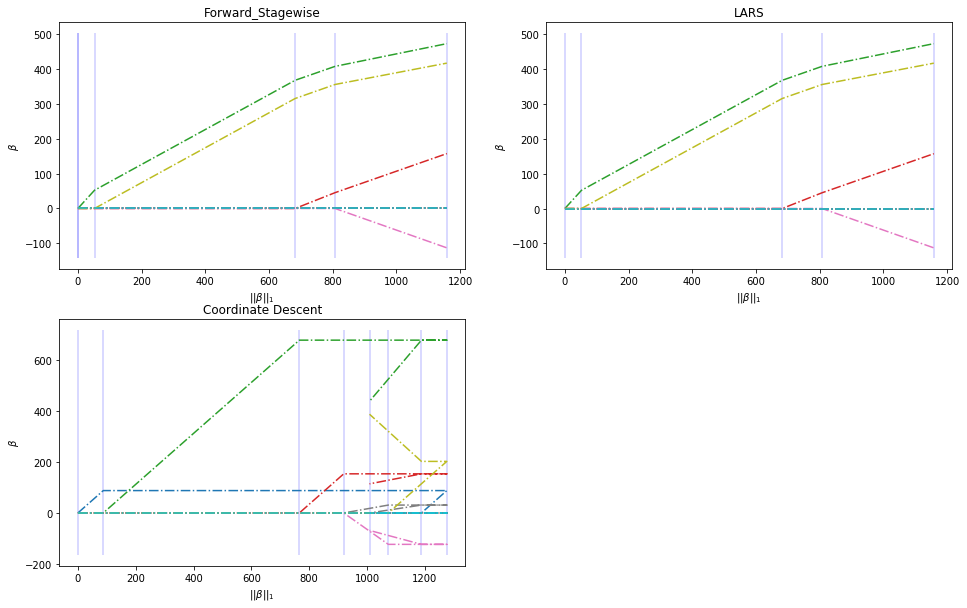

In [18]:
import time
import pandas as pd

def load_data():
    df = pd.read_csv('diabetes.csv')
    data = df.values
    # 我是直接从R包里找的数据集, 其本身包含了交互作用的数据, 我取得前10个表示不考虑交互作用
    #前400个数据作为训练集
    X_train = data[range(400), :10]
    y_train = data[range(400), 10]
    X_test = data[range(400, 442), :10]
    y_test = data[range(400, 442), 10]
    return X_train, y_train, X_test, y_test
    

if __name__ == '__main__':
    X, y, X_test, y_test = load_data()
    lasso_results = []

    def run_stw(X, y):

        time_stw = time.time()
        stw = stagewise()
        stw.fit(X, y, fit_intercept=True, Path=True, N_para=4) # N_para 表示选择的参数个数
        time_stw = time.time() - time_stw
        print('run time of stagewise is ', time_stw)
        print('iter steps of stagewise is ', stw.iter_step)
        print('coef. selected by stagewise is \n', stw.coef_.T) # [np.abs(stw.coef_) > 1e-10]



        return stw

    stw = run_stw(X, y)
    lasso_results.append(stw)

    def run_lars(X: object, y: object) -> object:

        time_lars = time.time()
        Lars = lars()
        Lars.fit(X, y, True, True, N_para=4)
        time_lars = time.time() - time_lars
        print('\n')
        print('run time of lars is ', time_lars)
        print('iter steps of lars is ', Lars.iter_step)
        print('coef. selected by lars is \n', Lars.coef_.T) # [np.abs(Lars.coef_ > 1e-10)]



        return Lars

    Lars = run_lars(X, y)
    lasso_results.append(Lars)

    def run_cod(X, y):

        time_cod: float = time.time()
        cod = CoorDescent()
        cod.fit(X, y, alpha=0.5, max_iter=1000, fit_intercept=True, Path=True)
        time_cod = time.time() - time_cod
        print('\n')
        print('run time of CoorDescent is ', time_cod)
        print('iter steps of CoorDescent is ', cod.iter_step)
        print('coef. selected by CoorDescent is \n', cod.coef_.T)

        return cod

    cod = run_cod(X, y)
    lasso_results.append(cod)

    lasso_plt(lasso_results)
    #
    #plt.show()


下面用测试集看一下模型的预测情况

In [8]:
y_cod = cod.predict(X_test) 
y_stw = stw.predict(X_test) 
y_lars = Lars.predict(X_test) 

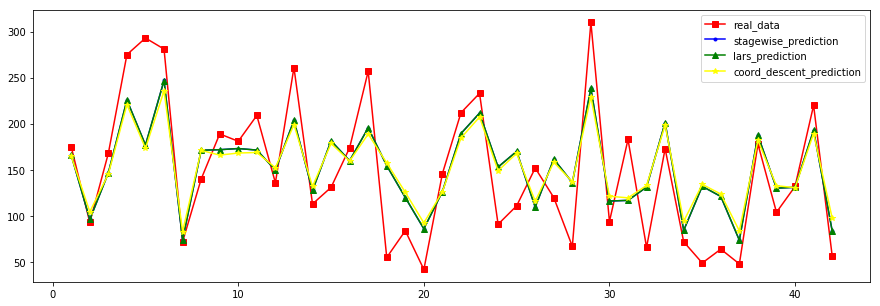

In [9]:
xx = range(1,43)
plt.figure(figsize=(15,5))
plt.plot(xx, y_test, 's-', color='red')
plt.plot(xx, y_stw, '.-', color='blue')
plt.plot(xx, y_lars, '^-', color='green')
plt.plot(xx, y_cod, '*-', color='yellow')
label = ['real_data', 'stagewise_prediction', 'lars_prediction', 'coord_descent_prediction']
plt.legend(label)
#plt.xlabel(r'$\beta$')